<a href="https://colab.research.google.com/github/Moonba/fastai/blob/main/04_mnist_basics_answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 10.9MB/s 
     |████████████████████████████████| 1.1MB 20.5MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 194kB 25.6MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

## Loading Data

In [3]:
URLs.MNIST_SAMPLE

'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
path

Path('/root/.fastai/data/mnist_sample')

In [6]:
type(path)

pathlib.PosixPath

In [7]:
Path.BASE_PATH = path

In [8]:
path.ls() # Prints list of elements, added by fast ai, check using path.ls? => desc, pasth.ls?? => func code

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
First, there is a division of train and validation data sets. Then, for each dataset we divide by target or label or class.


In [9]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [10]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [11]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [12]:
type(im3) #Python Image Library

PIL.PngImagePlugin.PngImageFile

1. How is a grayscale image represented on a computer? How about a color image?<br/>
To view the image, we convert it to a Numpy array or a Pytorch tensor: 

In [13]:
array(im3)[4:10,4:10] # 8 bits unsigned integer between 0 (represents white pixels) and 255 (represents black pixels)

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [14]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [15]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


`background_gradient` color codes the values using a gradient which shows us how the image is created from the pixel values. The image is 28*28 = 784 pixels
<br/>For colored images we will have 3 channels for each basic color Red Green Blue

## Naive approach: Pixel Similarity
Find the average pixel value for every pixel of the 3s and do the same for each of the 7s. Then to classify an image as digit, we compare to our 'ideal' 3 aor 7 average.

1. Explain how the "pixel similarity" approach to classifying digits works.

In [16]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

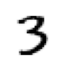

In [17]:
show_image(three_tensors[1]); # show_image is a fast ai method

In [18]:
three_tensors[1].shape # rank-2 tensor

torch.Size([28, 28])

In [19]:
type(three_tensors)


list

Turns the list in a rank-3 tensor (three- dimensional ):<br/> Divide by 255 to have values between 0 and 1

In [20]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [21]:
len(stacked_threes.shape)

3

In [22]:
stacked_threes.ndim # dimension in tensor ~ axis in numpy

3

In [23]:
stacked_threes.mean() # average pixel accross the whole cube rank-3 tensor

tensor(0.1415)

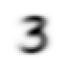

In [24]:
mean3 = stacked_threes.mean(0) # mean across axis 0, the 6131 axis
show_image(mean3);  # This is our 'ideal' three, it's dark where all images agree, blurry where the images disagree

In [25]:
mean3.shape # because we reduced the axis 0

torch.Size([28, 28])

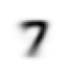

In [26]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

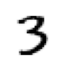

In [27]:
a_3 = stacked_threes[1]
show_image(a_3);

In [28]:
dist_3_abs = (a_3 - mean3).abs().mean() # L1 norm: Mean Absolute Difference
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() # L2 norm: RMSE
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [29]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

It's closer to the three than the seven

In [30]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### Understand NumPy Arrays and PyTorch Tensors

In [31]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [32]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [33]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [34]:
tns[1] # Equivalent to tns[1, :]

tensor([4, 5, 6])

In [35]:
tns[:,1]

tensor([2, 5])

In [36]:
tns[1,1:3]

tensor([5, 6])

In [37]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [38]:
tns.type()

'torch.LongTensor'

if you use the func type(tens) it will just tell you it's a tensor, if you use the method .type() it returns the type of the temsor

In [39]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting

In [40]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [41]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2)) # -1 The mean over the last dimension and -2: the second last dimension, the x and y axis
mnist_distance(a_3, mean3)

tensor(0.1114)

In [42]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [43]:
mean3.shape

torch.Size([28, 28])

In [44]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

That's broadcasting:
"automatically expanding the tensor with the smaller rank to have the same size as the one with the larger rank. 

*   PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't actually allocate any additional memory.
*   It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!)."

In [45]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1194, 0.1231, 0.1622,  ..., 0.1076, 0.1238, 0.1623]),
 torch.Size([1010]))

In [46]:
tensor([1,2,3]) + tensor([1,1,1]) # Broadcasting for element-wise addition

tensor([2, 3, 4])

In [47]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [48]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [49]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [50]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

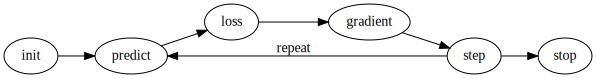

In [51]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [52]:
# quadratic func
def f(x): return x**2

/usr/local/lib/python3.6/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


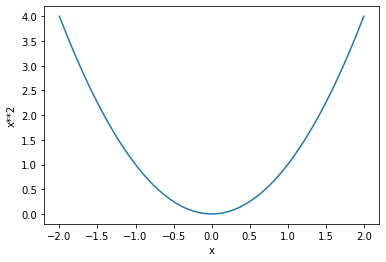

In [53]:
plot_function(f, 'x', 'x**2')

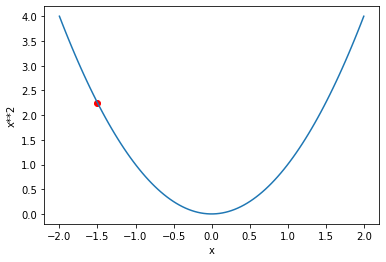

In [54]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

### Calculating Gradients

""In math or physics contexts the "gradient" of a function is just another function (i.e., its derivative), so you might expect gradient-related APIs to give you a new function. But in deep learning, "gradients" usually means the value of a function's derivative at a particular argument value. The PyTorch API also puts the focus on the argument, not the function you're actually computing the gradients of.""

In [55]:
xt = tensor(3.).requires_grad_()  # the last underscore _ in a method in pytorch, means it's an inplace operation, means it modifies the tensor(3.) 

`.requires_grad_()`  "tells PyTorch that we want to calculate gradients with respect to that variable at that value. It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for."

Below: "Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed"

In [56]:
yt = f(xt) # f(3) = 3 ** 2 = 9
yt

tensor(9., grad_fn=<PowBackward0>)

`.backward()` is backpropagation, which is the name given to the process of calculating the derivative of each layer.

In [57]:
yt.backward()  # calculate the gradients

In [58]:
xt.grad #  view the gradients: f'(3) = 2 * 3 = 6

tensor(6.)

In [59]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [60]:
def f(x): return (x**2).sum() #  take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor)

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [61]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate
*Stepping* your parameters, using an *optimizer step*: <br/>
w -= gradient(w) * lr <br/>
lr is often a number between 0.001 and 0.1. We can use *learning rate finder*

### An End-to-End SGD Example

Imagine we're gonna measure the speed of a roller coaster every second for an interval of 20 sec as it goes up than down (minimum speed will be a the top) 

In [62]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

Supposing a quadratic function with some noise since manual measurement may not be precise on the format: `a*(time**2)+(b*time)+ c`

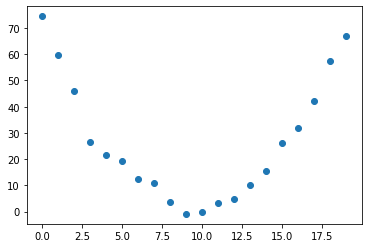

In [63]:
speed = 0.75*(time-9.5)**2 + torch.randn(20)*3 + 1
plt.scatter(time,speed);

In [64]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [65]:
def mse(preds, targets): return ((preds-targets)**2).mean()

#### Step 1: Initialize the parameters

" the weights of our model can be random (training from scratch) or come from a pretrained model (transfer learning)."

In [66]:
params = torch.randn(3).requires_grad_()

In [67]:
orig_params = params.clone() # save the weights to check them later

#### Step 2: Calculate the predictions

In [68]:
preds = f(time, params)

Let's see how our predictions compare to the real values:

In [69]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red') # our preds plot
    ax.set_ylim(-300,100)

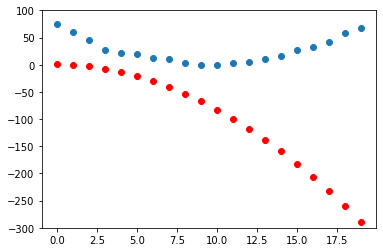

In [70]:
show_preds(preds)

We predicted negative speed which means the rollercoaster will go backwards xD

#### Step 3: Calculate the loss

In [71]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients
"In other words, calculate an approximation of how the parameters need to change:"

In [72]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

Each of our parameters has a negative gradient

In [73]:
params.grad * 1e-5 # lr = 10^-5

tensor([-0.5320, -0.0342, -0.0025])

In [74]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

#### Step 5: Step the weights. 

""a: Understanding this bit depends on remembering recent history. To calculate the gradients we call backward on the loss. But this loss was itself calculated by mse, which in turn took preds as an input, which was calculated using f taking as an input params, which was the object on which we originally called required_grads_—which is the original call that now allows us to call backward on loss. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.""

In [75]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [76]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

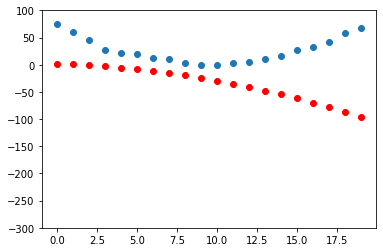

In [77]:
show_preds(preds)

In [78]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [79]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


In [80]:
params = orig_params.detach().requires_grad_()

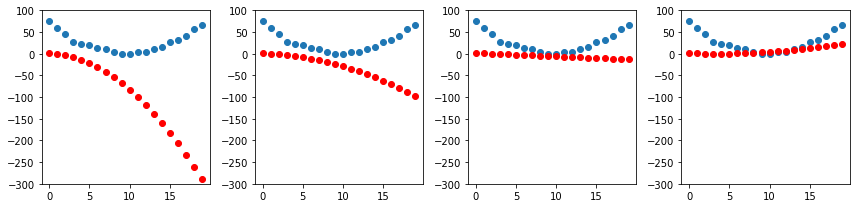

In [81]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

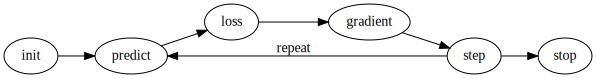

In [82]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

`.cat([stacked_threes, stacked_sevens])` concatenates all the images into a single tensor

Then change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor) using `view`:

"`view` is a PyTorch method that changes the shape of a tensor without changing its contents.<br/> -1 is a special parameter to view that means "make this axis as big as necessary to fit all the data"

In [83]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

Label for each image: We'll use 1 for 3s and 0 for 7s:

In [84]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. Python provides a zip function which, when combined with list, provides a simple way to get this functionality:

In [85]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

In [ ]:
bias = init_params(1)

In [ ]:
(train_x[0]*weights.T).sum() + bias

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

In [ ]:
corrects.float().mean().item()

In [ ]:
weights[0] *= 1.0001

In [ ]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
torch.where(trgts==1, 1-prds, prds)

In [ ]:
mnist_loss(prds,trgts)

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

### Sigmoid

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

## Putting It All Together

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
batch = train_x[:4]
batch.shape

In [ ]:
preds = linear1(batch)
preds

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [ ]:
(preds>0.0).float() == train_y[:4]

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

In [ ]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

In [ ]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

### Creating an Optimizer

In [ ]:
linear_model = nn.Linear(28*28,1)

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape

In [ ]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

In [ ]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [ ]:
validate_epoch(linear_model)

In [ ]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [ ]:
train_model(linear_model, 20)

In [ ]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

In [ ]:
dls = DataLoaders(dl, valid_dl)

In [ ]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(10, lr=lr)

## Adding a Nonlinearity

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [ ]:
plot_function(F.relu)

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(40, 0.1)

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
learn.recorder.values[-1][2]

### Going Deeper

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

## Jargon Recap

## Questionnaire


1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.